<a href="https://colab.research.google.com/github/nishant-jhaa/skin-cancer-detection/blob/main/skin_cancer_detection_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as seaborn
import matplotlib.pyplot as plt

**Load Images**

In [3]:
skin_images = "/content/drive/MyDrive/skin cancer/train"

In [4]:
skin_folders = os.listdir(skin_images)
print(skin_folders)

['benign', 'malignant']


In [5]:
skin_image_data = []
labels = []

In [6]:
label_dict = {
    'benign':0,
    'malignant':1
}

In [7]:
from keras.preprocessing import image

for ix in skin_folders:
    path = os.path.join(skin_images,ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size = ((512,512)))
        img_array = image.img_to_array(img)
        skin_image_data.append(img_array)
        labels.append(label_dict[ix])

In [8]:
print(len(skin_image_data),len(labels))

40 40


In [9]:
combined = list(zip(skin_image_data,labels))
skin_image_data[:],labels[:] = zip(*combined)

In [10]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
x_train = np.array(skin_image_data)
y_train = np.array(labels)

print(x_train.shape,y_train.shape)

(40, 512, 512, 3) (40,)


In [12]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
print(x_train.shape,y_train.shape)

(40, 512, 512, 3) (40, 2)


In [13]:
from keras.preprocessing.image import ImageDataGenerator

**Image data Augmentation**

In [14]:
augment = ImageDataGenerator( 
                             rotation_range=20,
                              width_shift_range=0.01, 
                              height_shift_range=0.01, 
                              horizontal_flip=False, 
                              vertical_flip=False,
                            )
augment.fit(x_train)

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

**Deep Ensemble CNN**

In [16]:
model = VGG16(include_top = False,weights = 'imagenet',input_shape = (512,512,3))

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [18]:
for ix in range(len(model.layers)):
    print(ix,model.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7faa6858f350>
1 <keras.layers.convolutional.Conv2D object at 0x7faa6810cf10>
2 <keras.layers.convolutional.Conv2D object at 0x7faa6733f2d0>
3 <keras.layers.pooling.MaxPooling2D object at 0x7faa67303050>
4 <keras.layers.convolutional.Conv2D object at 0x7faa673104d0>
5 <keras.layers.convolutional.Conv2D object at 0x7faa67313b10>
6 <keras.layers.pooling.MaxPooling2D object at 0x7faa67359e50>
7 <keras.layers.convolutional.Conv2D object at 0x7faa67318f50>
8 <keras.layers.convolutional.Conv2D object at 0x7faa63e0f1d0>
9 <keras.layers.convolutional.Conv2D object at 0x7faa63e07090>
10 <keras.layers.pooling.MaxPooling2D object at 0x7faa63e1a950>
11 <keras.layers.convolutional.Conv2D object at 0x7faa63e1e350>
12 <keras.layers.convolutional.Conv2D object at 0x7faa63e24a50>
13 <keras.layers.convolutional.Conv2D object at 0x7faa63e17a50>
14 <keras.layers.pooling.MaxPooling2D object at 0x7faa63e2f210>
15 <keras.layers.convolutional.Conv2D object at 

**Fine Tuning**

In [19]:
for layer in model.layers[:16]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [20]:
av1 = Flatten()(model.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_vgg = Model(model.input,fc3)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [22]:
model_1 = ResNet50(include_top=False, input_shape=(512,512,3), weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [23]:
model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [24]:
for ix in range(len(model_1.layers)):
    print(ix,model_1.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7faac735a710>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7faa63e07c50>
2 <keras.layers.convolutional.Conv2D object at 0x7faa63e07350>
3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7faa63e07290>
4 <keras.layers.core.activation.Activation object at 0x7faa63e3cf90>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x7faa639841d0>
6 <keras.layers.pooling.MaxPooling2D object at 0x7faa6393dc50>
7 <keras.layers.convolutional.Conv2D object at 0x7faa638eb710>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7faa638f2310>
9 <keras.layers.core.activation.Activation object at 0x7faa638f6f90>
10 <keras.layers.convolutional.Conv2D object at 0x7faa638f6390>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7faa63907490>
12 <keras.layers.core.activation.Activation object at 0x7faa63910510>
13 <keras.layers.convolutional.Conv2D object at 

In [25]:
for layer in model_1.layers[:169]:
    layer.trainable = False
for i, layer in enumerate(model_1.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [28]:
av1 = Flatten()(model_1.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_R = Model(model_1.input,fc3)
model_R.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

**Average Layer**

In [29]:
import tensorflow as tf
models = [model_R,model_vgg]
model_input = tf.keras.Input(shape=(512, 512, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.models.Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [30]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 2)            157838850   ['input_3[0][0]']                
                                                                                                  
 model (Functional)             (None, 2)            48302530    ['input_3[0][0]']                
                                                                                                  
 average (Average)              (None, 2)            0           ['model_1[0][0]',         

In [31]:
adam = Adam(learning_rate=0.0001)
ensemble_model.compile(loss='categorical_crossentropy',optimizer = adam,metrics=['accuracy'])

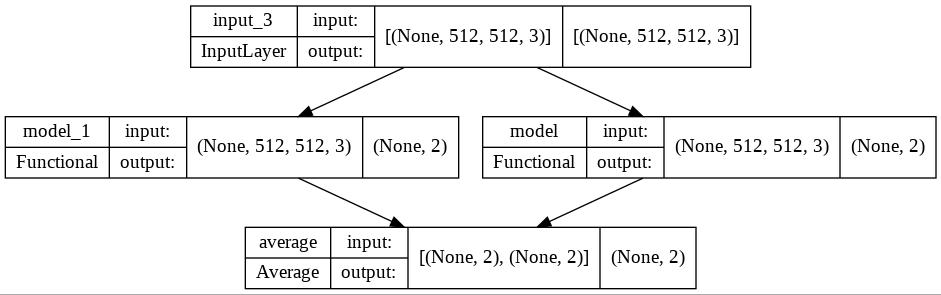

In [32]:
tf.keras.utils.plot_model(ensemble_model, 'model_1.jpg', show_shapes= True)

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [34]:
filepath="skin cancer_detection_ensemble1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=5)
callbacks_list = [checkpoint]

In [35]:
skin_hist = ensemble_model.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 25,
                    validation_split = 0.10,callbacks=callbacks_list)

Epoch 1/25
2/2 [==============================] - ETA: 0s - loss: 14.7659 - accuracy: 0.4444  
Epoch 1: val_loss improved from inf to 13.63027, saving model to skin cancer_detection_ensemble1.hdf5
2/2 [==============================] - 154s 37s/step - loss: 14.7659 - accuracy: 0.4444 - val_loss: 13.6303 - val_accuracy: 0.5000
Epoch 2/25
2/2 [==============================] - ETA: 0s - loss: 13.6988 - accuracy: 0.6389  
Epoch 2: val_loss improved from 13.63027 to 12.80747, saving model to skin cancer_detection_ensemble1.hdf5
2/2 [==============================] - 147s 38s/step - loss: 13.6988 - accuracy: 0.6389 - val_loss: 12.8075 - val_accuracy: 0.7500
Epoch 3/25
2/2 [==============================] - ETA: 0s - loss: 12.6453 - accuracy: 0.8611  
Epoch 3: val_loss improved from 12.80747 to 12.10645, saving model to skin cancer_detection_ensemble1.hdf5
2/2 [==============================] - 145s 36s/step - loss: 12.6453 - accuracy: 0.8611 - val_loss: 12.1064 - val_accuracy: 0.7500
Epoch 

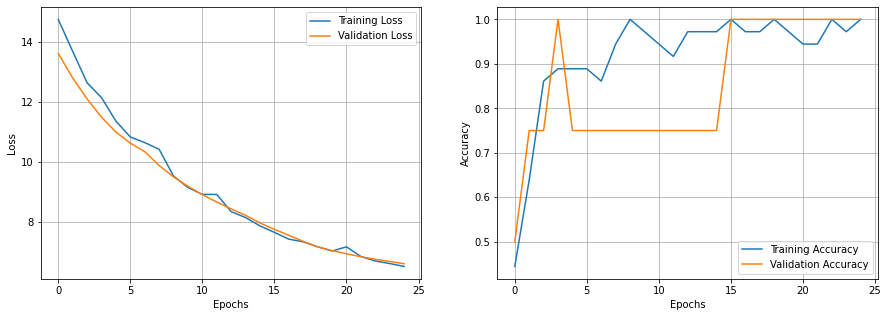

In [36]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( skin_hist.history["loss"], label = "Training Loss")
plt.plot( skin_hist.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( skin_hist.history["accuracy"], label = "Training Accuracy")
plt.plot( skin_hist.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

**Testing Ensemble Learning**

In [38]:
test_images = "/content/drive/MyDrive/skin cancer/test"

test_image_data = []
test_labels = []

test_folders = os.listdir(test_images)
print(test_folders)

label_dict = {
    'benign':0,
    'malignant':1
}

from keras.preprocessing import image

for ix in test_folders:
    path = os.path.join(test_images,ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size = ((512,512)))
        img_array = image.img_to_array(img)
        test_image_data.append(img_array)
        test_labels.append(label_dict[ix])
        

combined = list(zip(test_image_data,test_labels))
test_image_data[:],test_labels[:] = zip(*combined)

x_test = np.array(test_image_data)
y_test = np.array(test_labels)

from keras.utils import np_utils

y_test = np_utils.to_categorical(y_test)
print(x_test.shape,y_test.shape)

['malignant', 'benign']
(40, 512, 512, 3) (40, 2)


In [39]:
ensemble_model.evaluate(x_test,y_test)

2/2 [==============================] - 129s 27s/step - loss: 6.8505 - accuracy: 0.8000


[6.850531101226807, 0.800000011920929]

In [40]:
from sklearn.metrics import classification_report,confusion_matrix

In [41]:
predictions = ensemble_model.predict(x_test, batch_size = 32)
pred = np.argmax(predictions, axis=1)

In [42]:
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.80      0.80      0.80        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



In [43]:
print(confusion_matrix(test_labels, pred))

[[16  4]
 [ 4 16]]


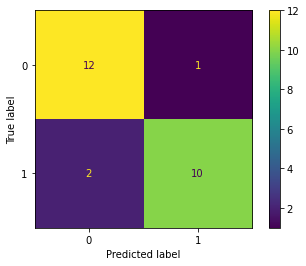

In [48]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
ConfusionMatrixDisplay.from_estimator(
clf, X_test, y_test)
plt.show()